In [67]:
#Import Libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import joblib


In [68]:
#  Load Dataset
DATA_PATH = "indian_liver_patient.csv"  
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (583, 11)


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [69]:
# Basic Info & Missing Values
print(df.info())
print("\nMissing values (before handling):")
display(df.isnull().sum().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB
None

Missing values (before handling):


Albumin_and_Globulin_Ratio    4
Gender                        0
Age                           0
Total_Bilirubin               0
Direct_Bilirubin              0
Alamine_Aminotransferase      0
Alkaline_Phosphotase          0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Dataset                       0
dtype: int64

In [70]:
 # Smart Missing Value Handling
def smart_fillna(df):
    df = df.copy()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    before = df.isnull().sum()
    
    for col in num_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())
    for col in cat_cols:
        if df[col].isnull().any():
            mode = df[col].mode()
            val = mode[0] if len(mode)>0 else "missing"
            df[col] = df[col].fillna(val)
            
    after = df.isnull().sum()
    summary = pd.DataFrame({"before": before, "after": after})
    return df, summary

df, missing_summary = smart_fillna(df)
print("Missing summary:")
display(missing_summary[missing_summary.before > 0])


Missing summary:


,before,after
Albumin_and_Globulin_Ratio,4,0


In [71]:
# Detect outliers using IQR method
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
print("Numeric columns:", numeric_cols)

Numeric columns: ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio', 'Dataset']


In [72]:
print("\n Checking for outliers using IQR method...\n")
outlier_summary = {}

for col in numeric_cols:
    if col.lower() not in ['Dataset', 'target']:  # exclude target variable if numeric
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_summary[col] = outliers



 Checking for outliers using IQR method...



In [73]:
# Visualize outliers (boxplots for top 4 columns)
# Convert to DataFrame for sorting
outliers_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count']).sort_values(by='Outlier Count', ascending=False)

#  Select top 4 columns with most outliers
top_cols = outliers_df.head(4).index.tolist()

In [74]:
#  Handle outliers using IQR capping 
for col in numeric_cols:
    if col.lower() not in ['Dataset', 'target']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound,
                                np.where(df[col] > upper_bound, upper_bound, df[col]))


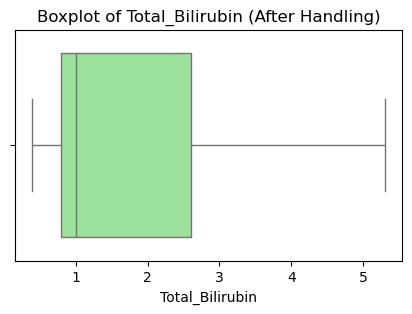

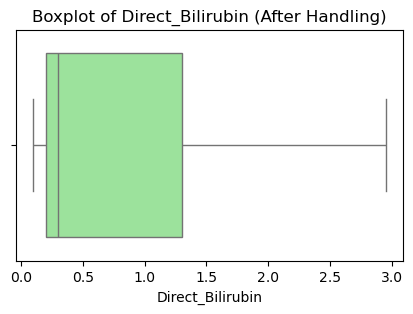

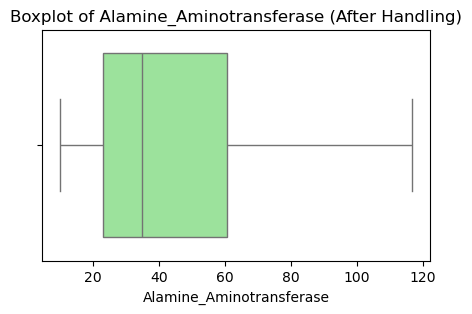

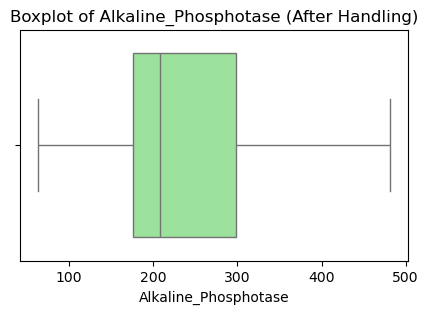

In [75]:
# Verify after handling
for col in top_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Boxplot of {col} (After Handling)")
    plt.show()

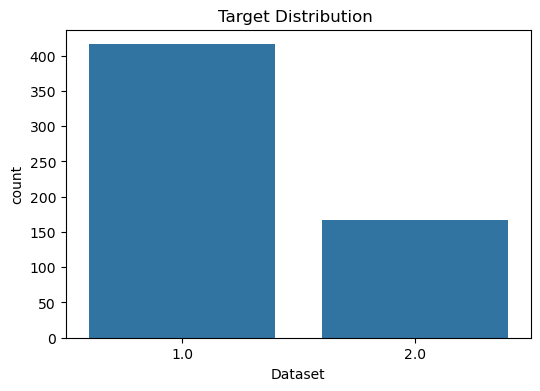

In [76]:
#EDA - Target and Correlations
TARGET = "Dataset" 
if TARGET not in df.columns:
    print("⚠️ Target column name may differ. Check df.columns and update TARGET variable.")

plt.figure(figsize=(6,4))
sns.countplot(x=df[TARGET])
plt.title("Target Distribution ")
plt.show()

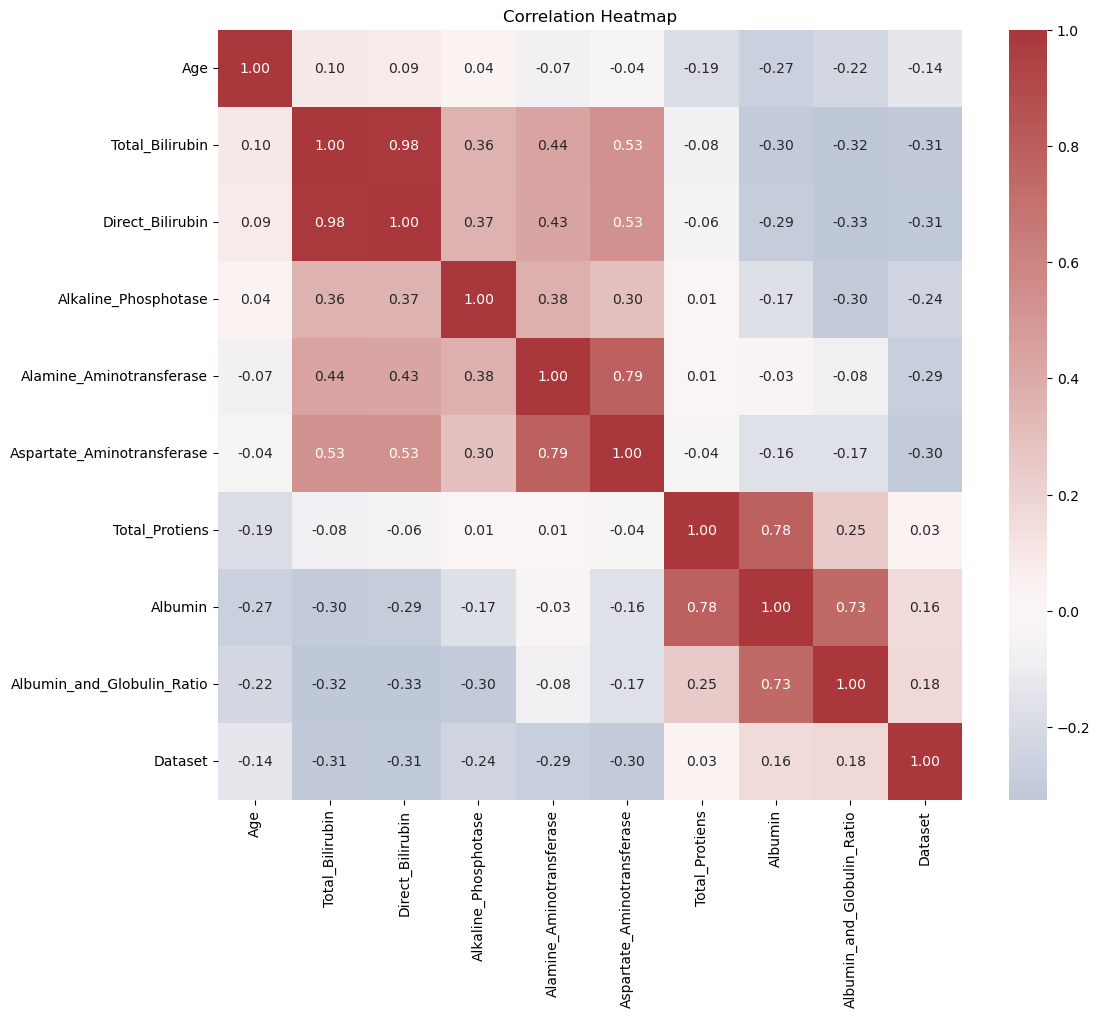

In [77]:
num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12,10))
sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation Heatmap")
plt.show()

In [78]:
# Split Features and Target
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio']
Categorical features: ['Gender']


In [79]:
#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (466, 10) Test shape: (117, 10)


In [80]:
# Preprocessing Pipelines
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


In [81]:
# Model Pipelines
models = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=100),
    "SVM": SVC(random_state=42, probability=True),
    "KNN": KNeighborsClassifier()
}

pipelines = {name: Pipeline([("preprocessor", preprocessor), ("classifier", model)]) for name, model in models.items()}


In [82]:
# Train, Predict & Evaluate
metrics_list = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipe in pipelines.items():
    print(f"\nTraining {name}...")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cv_f1 = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1").mean()

    metrics_list.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "cv_f1": cv_f1
    })

pd.DataFrame(metrics_list)



Training LogisticRegression...

Training DecisionTree...

Training RandomForest...

Training SVM...

Training KNN...


,model,accuracy,precision,recall,f1,cv_f1
0,LogisticRegression,0.692308,0.742268,0.867470,0.800000,0.816039
1,DecisionTree,0.598291,0.719512,0.710843,0.715152,0.731255
2,RandomForest,0.606838,0.703297,0.771084,0.735632,0.831074
3,SVM,0.666667,0.703704,0.915663,0.795812,0.812065
4,KNN,0.666667,0.768293,0.759036,0.763636,0.784082


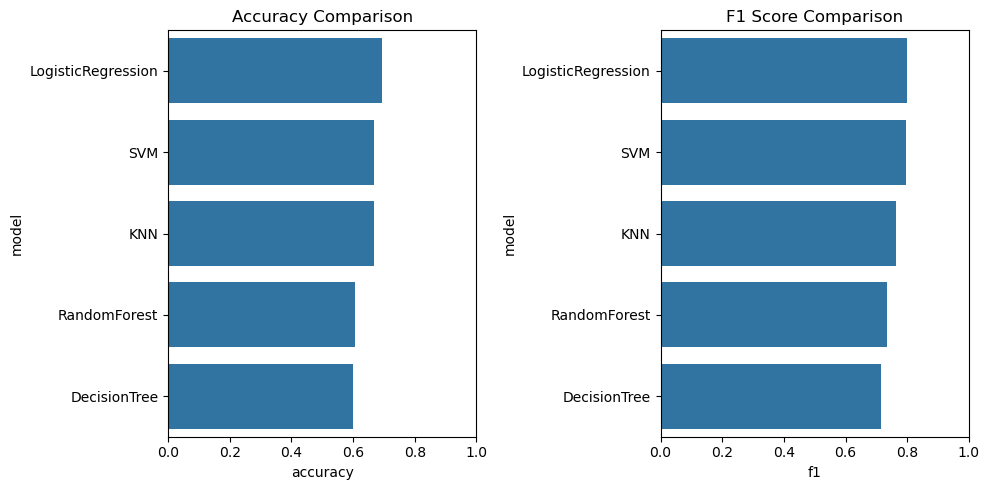

,model,accuracy,precision,recall,f1,cv_f1
0,LogisticRegression,0.692308,0.742268,0.867470,0.800000,0.816039
3,SVM,0.666667,0.703704,0.915663,0.795812,0.812065
4,KNN,0.666667,0.768293,0.759036,0.763636,0.784082
2,RandomForest,0.606838,0.703297,0.771084,0.735632,0.831074
1,DecisionTree,0.598291,0.719512,0.710843,0.715152,0.731255


In [83]:
#  Compare Models with Graphs
metrics_df = pd.DataFrame(metrics_list).sort_values(by="f1", ascending=False)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.barplot(x="accuracy", y="model", data=metrics_df)
plt.title("Accuracy Comparison")
plt.xlim(0,1)

plt.subplot(1,2,2)
sns.barplot(x="f1", y="model", data=metrics_df)
plt.title("F1 Score Comparison")
plt.xlim(0,1)

plt.tight_layout()
plt.show()

metrics_df


Best Model: LogisticRegression

Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.87      0.80        83
           2       0.45      0.26      0.33        34

    accuracy                           0.69       117
   macro avg       0.60      0.57      0.57       117
weighted avg       0.66      0.69      0.66       117



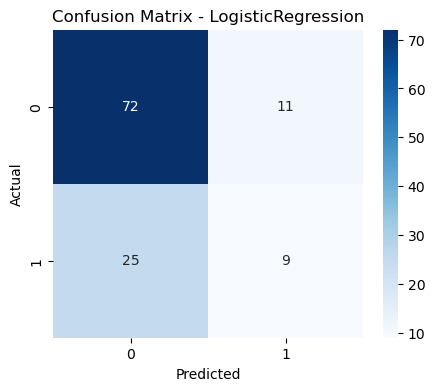

In [84]:
# Confusion Matrix & Classification Report for Best Model
best_model = metrics_df.iloc[0]["model"]
print("Best Model:", best_model)

best_pipe = pipelines[best_model]
y_pred_best = best_pipe.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_model}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [85]:
import pickle

# Save the best pipeline for Liver Disease
with open("Liver_model.pkl", "wb") as f:
    pickle.dump(best_pipe, f)

print("✅ Liver Disease model saved successfully!")


✅ Liver Disease model saved successfully!


In [86]:
with open("Liver_model.pkl", "rb") as f:
    model = pickle.load(f)

print("✅ Model loaded successfully!")
print(type(model))


✅ Model loaded successfully!
<class 'sklearn.pipeline.Pipeline'>
